In [98]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [175]:
%matplotlib inline

In [351]:
# load csv

df = pd.read_csv("./CandidateSummaryAction1.csv")
df.head()

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_str2,can_cit,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,cov_sta_dat,cov_end_dat,winner,votes
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,NaN,AUGUSTA,...,"$60,109.57","$175,613.35","$1,074,949.50","$907,156.21","$1,125,000.00",NaN,1/1/2015,10/19/2016,Y,158708.0
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,NaN,PHILADELPHIA,...,NaN,"$105,687.23","$1,406,719.06","$1,298,831.83",NaN,NaN,11/2/2015,10/19/2016,Y,310770.0
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,NaN,JACKSONVILLE,...,NaN,"$35,645.09","$650,855.38","$656,210.29","$60,000.00",NaN,4/1/2016,10/19/2016,Y,286018.0
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,NaN,WHITEFISH,...,"$83,815.78","$399,122.61","$4,938,943.74","$5,055,942.15",NaN,NaN,1/1/2015,10/19/2016,Y,280476.0
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",NaN,OAKLAND,...,"$83,690.60","$181,338.23","$1,197,676.61","$949,488.98","$4,401.75",NaN,1/1/2015,10/19/2016,Y,277390.0


~~we want to remove anyone who got 0 votes - also want to look for more tightly contested races as our question~~ can't do this because the data set is missing votes for those who missed
since our question doesn't really pertain to unopposed or landslide campaigns

aggregate based on candidate_incumbent_challenger_open_seat as one
type of office cand_office for house/senate/pres
can also group spending by states cand_office_st
cand_office_dist might be interesting to see spending across a state

type of contributions - can compare individual_contribution
other_committee_contribution - contributions from pacs/other candidates
cand_contribution - from self
party_committee_contribution - from state/national party committees
total contribution
coverage_start_date - when a candidate started reporting finances note- dates are from 1/1/2015 - 10/19/2016
winner column represents if that candidate won - can be represented with boolean

is there a correlation between spending and cook partisan index(do this later)

In [349]:
df.columns

Index(['can_id', 'can_nam', 'can_off', 'can_off_sta', 'can_off_dis',
       'can_par_aff', 'can_inc_cha_ope_sea', 'can_str1', 'can_str2', 'can_cit',
       'can_sta', 'can_zip', 'ind_ite_con', 'ind_uni_con', 'ind_con',
       'par_com_con', 'oth_com_con', 'can_con', 'tot_con',
       'tra_fro_oth_aut_com', 'can_loa', 'oth_loa', 'tot_loa',
       'off_to_ope_exp', 'off_to_fun', 'off_to_leg_acc', 'oth_rec', 'tot_rec',
       'ope_exp', 'exe_leg_acc_dis', 'fun_dis', 'tra_to_oth_aut_com',
       'can_loa_rep', 'oth_loa_rep', 'tot_loa_rep', 'ind_ref', 'par_com_ref',
       'oth_com_ref', 'tot_con_ref', 'oth_dis', 'tot_dis',
       'cas_on_han_beg_of_per', 'cas_on_han_clo_of_per', 'net_con',
       'net_ope_exp', 'deb_owe_by_com', 'deb_owe_to_com', 'cov_sta_dat',
       'cov_end_dat', 'winner', 'votes'],
      dtype='object')

In [355]:
parsed_df = df[['can_nam', 'can_off', 'can_off_sta', 'can_off_dis', 'can_par_aff', 'can_inc_cha_ope_sea', 'ind_con', 'can_con', 'oth_com_con', 'tot_con', 'tot_dis', 'winner', 'votes']]
parsed_df

,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,ind_con,can_con,oth_com_con,tot_con,tot_dis,winner,votes
0,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,"$601,274.50",NaN,"$473,675.00","$1,074,949.50","$978,518.98",Y,158708.0
1,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,"$1,114,711.02",NaN,"$302,834.20","$1,417,545.22","$1,313,583.69",Y,310770.0
2,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,"$542,105.38","$2,700.00","$106,050.00","$650,855.38","$675,642.76",Y,286018.0
3,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,"$4,317,331.58",NaN,"$660,038.51","$4,980,915.41","$5,200,630.00",Y,280476.0
4,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"$897,123.61",NaN,"$308,740.00","$1,205,863.61","$1,112,163.94",Y,277390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,"BUTTOCKS, SYDNEYS VOLUPTOUS",P,US,0.0,IND,OPEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1810,"MOLNAR, ROBERT",S,CA,0.0,REP,OPEN,NaN,"$1,000.00",NaN,"$1,000.00","$2,000.00",NaN,NaN
1811,"HOLMES, GREGORY",S,MD,0.0,REP,OPEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1812,"HUNKIN-FINAU, VAITINASA SALU",H,AS,NaN,DEM,NaN,"$20,555.00","$12,900.00",NaN,"$41,670.00","$38,167.44",NaN,NaN


In [356]:
fill_values = {"can_con": 0.0, "ind_con": 0.0, "tot_con": 0.0, "oth_com_con": 0.0, "tot_dis": 0.0, "winner": "N" }
parsed_df = parsed_df.fillna(value=fill_values)
parsed_df

,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,ind_con,can_con,oth_com_con,tot_con,tot_dis,winner,votes
0,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,"$601,274.50",0.0,"$473,675.00","$1,074,949.50","$978,518.98",Y,158708.0
1,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,"$1,114,711.02",0.0,"$302,834.20","$1,417,545.22","$1,313,583.69",Y,310770.0
2,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,"$542,105.38","$2,700.00","$106,050.00","$650,855.38","$675,642.76",Y,286018.0
3,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,"$4,317,331.58",0.0,"$660,038.51","$4,980,915.41","$5,200,630.00",Y,280476.0
4,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"$897,123.61",0.0,"$308,740.00","$1,205,863.61","$1,112,163.94",Y,277390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,"BUTTOCKS, SYDNEYS VOLUPTOUS",P,US,0.0,IND,OPEN,0.0,0.0,0.0,0.0,0.0,N,NaN
1810,"MOLNAR, ROBERT",S,CA,0.0,REP,OPEN,0.0,"$1,000.00",0.0,"$1,000.00","$2,000.00",N,NaN
1811,"HOLMES, GREGORY",S,MD,0.0,REP,OPEN,0.0,0.0,0.0,0.0,0.0,N,NaN
1812,"HUNKIN-FINAU, VAITINASA SALU",H,AS,NaN,DEM,NaN,"$20,555.00","$12,900.00",0.0,"$41,670.00","$38,167.44",N,NaN


In [154]:
parsed_df[parsed_df['winner'] != 'Y']

,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,ind_con,can_con,tot_con,winner,votes
382,"FOX, RANDY",H,CA,41.0,REP,CHALLENGER,"$64,065.00","$1,000.00","$67,065.00",N,NaN
383,"GRAHAM, JOHN COLLINS",S,CO,0.0,REP,CHALLENGER,"$462,280.00","$21,567.00","$483,847.00",N,NaN
384,"CARO, SUZANNE M",H,CA,13.0,REP,CHALLENGER,"$3,050.00","$1,471.00","$4,521.00",N,NaN
385,"EVANS, ROBERT S",H,CA,6.0,REP,CHALLENGER,"$2,805.00",0.0,"$2,805.00",N,NaN
386,"FISCHELLA, TYLER R",H,CA,35.0,REP,CHALLENGER,"$2,740.29",$762.36,"$3,502.65",N,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1809,"BUTTOCKS, SYDNEYS VOLUPTOUS",P,US,0.0,IND,OPEN,0.0,0.0,0.0,N,NaN
1810,"MOLNAR, ROBERT",S,CA,0.0,REP,OPEN,0.0,"$1,000.00","$1,000.00",N,NaN
1811,"HOLMES, GREGORY",S,MD,0.0,REP,OPEN,0.0,0.0,0.0,N,NaN
1812,"HUNKIN-FINAU, VAITINASA SALU",H,AS,NaN,DEM,NaN,"$20,555.00","$12,900.00","$41,670.00",N,NaN


In [101]:
re.sub('[^0-9\.]', '', parsed_df['ind_con'][0])

'601274.50'

In [357]:
parsed_df['ind_con'] = parsed_df.ind_con.map(lambda x: float(re.sub('[^0-9\.]', '', str(x))))

In [358]:
parsed_df['can_con'] = parsed_df.can_con.map(lambda x: float(re.sub('[^0-9\.]', '', str(x))))

In [359]:
parsed_df['tot_con'] = parsed_df.tot_con.map(lambda x: float(re.sub('[^0-9\.]', '', str(x))))

In [360]:
parsed_df['tot_dis'] = parsed_df.tot_dis.map(lambda x: float(re.sub('[^0-9\.]', '', str(x))))

In [361]:
parsed_df['oth_com_con'] = parsed_df.oth_com_con.map(lambda x: float(re.sub('[^0-9\.]', '', str(x))))

In [362]:
parsed_df[(parsed_df['can_off_sta'] == 'GA') & (parsed_df['can_off_dis'] == 12.0)]

,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,ind_con,can_con,oth_com_con,tot_con,tot_dis,winner,votes
0,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,601274.50,0.0,473675.0,1074949.50,978518.98,Y,158708.0
726,"MCCRACKEN, TRICIA CARPENTER",H,GA,12.0,DEM,CHALLENGER,0.00,6882.0,0.0,13764.64,10440.00,N,NaN
1080,"YU, EUGENE MR.",H,GA,12.0,REP,CHALLENGER,28007.87,0.0,0.0,28007.87,55423.31,N,NaN


In [363]:
parsed_df = parsed_df[parsed_df["tot_dis"] != 0.0]
parsed_df = parsed_df[parsed_df["tot_con"] != 0.0]
party_parse_array = ['REP', 'DEM', 'LIB', 'IND', 'GRE']
parsed_df = parsed_df[parsed_df["can_par_aff"].isin(party_parse_array)]

In [364]:
parsed_df['can_par_aff'].unique()

array(['REP', 'DEM', 'LIB', 'IND', 'GRE'], dtype=object)

In [377]:
# winners and losers
winner_df = parsed_df[parsed_df["winner"] == 'Y']
loser_df = parsed_df[parsed_df["winner"] == 'N']

In [378]:
winner_df
loser_df
winner_df["tot_con"].describe()

count    4.650000e+02
mean     2.221969e+06
std      5.762780e+06
min      2.415732e+05
25%      8.837652e+05
50%      1.263560e+06
75%      2.020066e+06
max      1.144922e+08
Name: tot_con, dtype: float64

In [ ]:
# create a plot of spending vs. victory

In [367]:
parsed_df.sort_values(by=['tot_dis'], ascending=False)

,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,ind_con,can_con,oth_com_con,tot_con,tot_dis,winner,votes
1359,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",P,US,0.0,DEM,OPEN,3.582784e+08,1350632.01,1686586.71,3.613296e+08,4.505656e+08,N,NaN
1319,"TRUMP, DONALD J. / MICHAEL R. PENCE",P,US,0.0,REP,OPEN,1.057999e+08,8599568.25,87905.50,1.144922e+08,2.389627e+08,Y,NaN
1425,"SANDERS, BERNARD",P,US,0.0,DEM,OPEN,2.318316e+08,0.00,5621.92,2.318372e+08,2.320313e+08,N,NaN
1473,"CRUZ, RAFAEL EDWARD TED""""",P,US,0.0,REP,OPEN,9.203612e+07,0.00,101095.14,9.213722e+07,9.337319e+07,N,NaN
1332,"CARSON, BENJAMIN S SR MD",P,US,0.0,REP,OPEN,6.346140e+07,0.00,5588.29,6.346699e+07,6.425823e+07,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,"RUCKER, AUSTIN JONATHAN",H,MO,5.0,REP,CHALLENGER,1.700000e+02,100.00,0.00,3.100000e+02,1.700000e+01,N,NaN
1202,"JACKSON, TROY",H,ME,1.0,DEM,CHALLENGER,2.684700e+02,0.00,0.00,2.684700e+02,1.500000e+01,N,NaN
1024,"ROGERS, EVELYN L (LOUISE)",H,OK,1.0,REP,CHALLENGER,0.000000e+00,1147.00,0.00,1.147000e+03,6.000000e+00,N,NaN
1591,"SMITH, WILLIAM ROGER",P,US,0.0,IND,OPEN,0.000000e+00,605.00,0.00,2.640000e+02,3.000000e+00,N,NaN


In [372]:
parsed_df = parsed_df[parsed_df["ind_con"]/parsed_df["tot_con"] < 1]


count    1.380000e+03
mean     1.840837e+06
std      1.556043e+07
min      3.000000e+00
25%      3.891921e+04
50%      3.341533e+05
75%      1.052783e+06
max      4.505656e+08
Name: tot_dis, dtype: float64

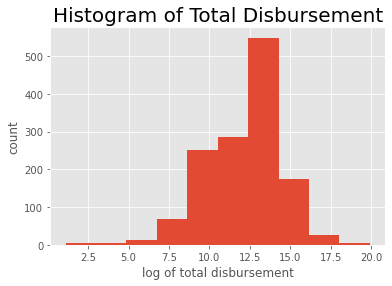

In [369]:
sorted_log_tot_dis = np.log(parsed_df["tot_dis"].sort_values(ascending=False))
# log of sorted total disbursement - how much was spent by the campaign
plt.hist(sorted_log_tot_dis)
plt.xlabel('log of total disbursement')
plt.ylabel('count')
plt.title("Histogram of Total Disbursement", fontsize = 20)
parsed_df["tot_dis"].describe()

count    1.380000e+03
mean     1.840837e+06
std      1.556043e+07
min      3.000000e+00
25%      3.891921e+04
50%      3.341533e+05
75%      1.052783e+06
max      4.505656e+08
Name: tot_dis, dtype: float64

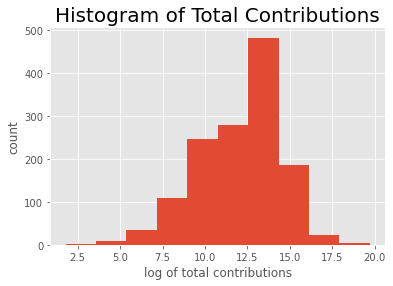

In [370]:
sorted_log_tot_dis = np.log(parsed_df["tot_con"].sort_values(ascending=False))
# log of sorted total contributions - how much was collected by the campaign
plt.hist(sorted_log_tot_dis)
plt.xlabel('log of total contributions')
plt.ylabel('count')
plt.title("Histogram of Total Contributions", fontsize = 20)
parsed_df["tot_dis"].describe()

In [ ]:
# proportion of contributions that are individual out of 
# total contributions (pacs), and associated party color

Text(0.5, 1.0, 'Proportion of contributions from individuals vs. log of Total Campaign Contributions')

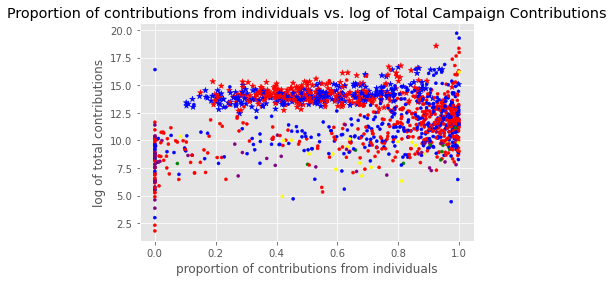

In [390]:
individual_con_percentage_win = winner_df["ind_con"]/winner_df["tot_con"]
total_con_log_win = np.log(winner_df["tot_con"])
party_winner = winner_df['can_par_aff']

individual_con_percentage_lose = loser_df["ind_con"]/loser_df["tot_con"]
total_con_log_lose = np.log(loser_df["tot_con"])
party_lose = loser_df['can_par_aff']

new_df_wins = pd.DataFrame(dict(party=party_winner, ind_con_percentage=individual_con_percentage_win, total_con_log=total_con_log_win))
new_df_lose = pd.DataFrame(dict(party=party_lose, ind_con_percentage=individual_con_percentage_lose, total_con_log=total_con_log_lose))


fig, ax = plt.subplots()
'REP', 'DEM', 'LIB', 'IND', 'GRE'
colors = {'REP': 'red', 'DEM': 'blue', 'IND': 'purple', 'LIB': 'yellow', 'GRE': 'green'}


ax.scatter(new_df_wins['ind_con_percentage'], new_df_wins['total_con_log'], c=new_df_wins['party'].map(colors), marker="*")
ax.scatter(new_df_lose['ind_con_percentage'], new_df_lose['total_con_log'], c=new_df_lose['party'].map(colors), marker=".")


plt.xlabel('proportion of contributions from individuals')
plt.ylabel('log of total contributions')
plt.title("Proportion of contributions from individuals vs. log of Total Campaign Contributions")


Text(0, 0.5, 'log of total contributions')

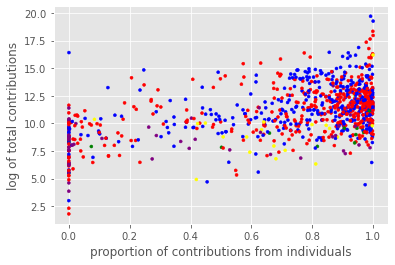

In [380]:
individual_con_percentage_lose = loser_df["ind_con"]/loser_df["tot_con"]
total_con_log_lose = np.log(loser_df["tot_con"])
party_lose = loser_df['can_par_aff']

new_df_lose = pd.DataFrame(dict(party=party_lose, ind_con_percentage=individual_con_percentage_lose, total_con_log=total_con_log_lose))

fig, ax = plt.subplots()
'REP', 'DEM', 'LIB', 'IND', 'GRE'
colors = {'REP': 'red', 'DEM': 'blue', 'IND': 'purple', 'LIB': 'yellow', 'GRE': 'green'}

ax.scatter(new_df_lose['ind_con_percentage'], new_df_lose['total_con_log'], c=new_df_lose['party'].map(colors), marker=".")


plt.xlabel('proportion of contributions from individuals')
plt.ylabel('log of total contributions')
# plt.title("Losing proportion of contributions from individuals vs. log of total campaign contributions")

Text(0, 0.5, 'log of total contributions')

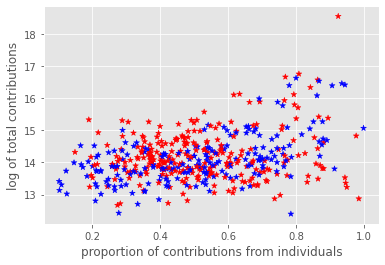

In [381]:
individual_con_percentage_win = winner_df["ind_con"]/winner_df["tot_con"]
total_con_log_win = np.log(winner_df["tot_con"])
party_winner = winner_df['can_par_aff']

individual_con_percentage_lose = loser_df["ind_con"]/loser_df["tot_con"]
total_con_log_lose = np.log(loser_df["tot_con"])
party_lose = loser_df['can_par_aff']

new_df_wins = pd.DataFrame(dict(party=party_winner, ind_con_percentage=individual_con_percentage_win, total_con_log=total_con_log_win))
new_df_lose = pd.DataFrame(dict(party=party_lose, ind_con_percentage=individual_con_percentage_lose, total_con_log=total_con_log_lose))


fig, ax = plt.subplots()
'REP', 'DEM', 'LIB', 'IND', 'GRE'
colors = {'REP': 'red', 'DEM': 'blue', 'IND': 'purple', 'LIB': 'yellow', 'GRE': 'green'}


ax.scatter(new_df_wins['ind_con_percentage'], new_df_wins['total_con_log'], c=new_df_wins['party'].map(colors), marker="*")
# ax.scatter(new_df_lose['ind_con_percentage'], new_df_lose['total_con_log'], c=new_df_lose['party'].map(colors), marker=".")


plt.xlabel('proportion of contributions from individuals')
plt.ylabel('log of total contributions')
# plt.title("Winning proportion of contributions from individuals vs. log of total campaign contributions")

Text(0, 0.5, 'log of total contributions')

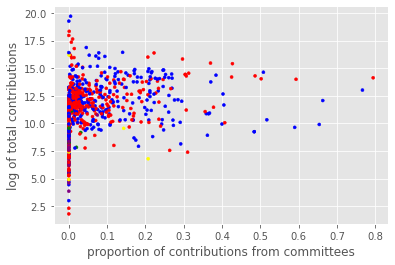

In [388]:
com_percentage_win = winner_df["oth_com_con"]/winner_df["tot_con"]
total_con_log_win = np.log(winner_df["tot_con"])
party_winner = winner_df['can_par_aff']

com_percentage_lose = loser_df["oth_com_con"]/loser_df["tot_con"]
total_con_log_lose = np.log(loser_df["tot_con"])
party_lose = loser_df['can_par_aff']

new_df_wins = pd.DataFrame(dict(party=party_winner, com_percentage=com_percentage_win, total_con_log=total_con_log_win))
new_df_lose = pd.DataFrame(dict(party=party_lose, com_percentage=com_percentage_lose, total_con_log=total_con_log_lose))


fig, ax = plt.subplots()
'REP', 'DEM', 'LIB', 'IND', 'GRE'
colors = {'REP': 'red', 'DEM': 'blue', 'IND': 'purple', 'LIB': 'yellow', 'GRE': 'green'}


# ax.scatter(new_df_wins['com_percentage'], new_df_wins['total_con_log'], c=new_df_wins['party'].map(colors), marker="*")
ax.scatter(new_df_lose['com_percentage'], new_df_lose['total_con_log'], c=new_df_lose['party'].map(colors), marker=".")


plt.xlabel('proportion of contributions from committees')
plt.ylabel('log of total contributions')
# plt.title("Losing proportion of contributions from individuals vs. log of total campaign contributions")

Text(0, 0.5, 'log of total contributions')

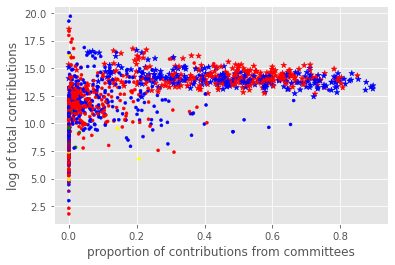

In [391]:
com_percentage_win = winner_df["oth_com_con"]/winner_df["tot_con"]
total_con_log_win = np.log(winner_df["tot_con"])
party_winner = winner_df['can_par_aff']

com_percentage_lose = loser_df["oth_com_con"]/loser_df["tot_con"]
total_con_log_lose = np.log(loser_df["tot_con"])
party_lose = loser_df['can_par_aff']

new_df_wins = pd.DataFrame(dict(party=party_winner, com_percentage=com_percentage_win, total_con_log=total_con_log_win))
new_df_lose = pd.DataFrame(dict(party=party_lose, com_percentage=com_percentage_lose, total_con_log=total_con_log_lose))


fig, ax = plt.subplots()
'REP', 'DEM', 'LIB', 'IND', 'GRE'
colors = {'REP': 'red', 'DEM': 'blue', 'IND': 'purple', 'LIB': 'yellow', 'GRE': 'green'}


ax.scatter(new_df_wins['com_percentage'], new_df_wins['total_con_log'], c=new_df_wins['party'].map(colors), marker="*")
ax.scatter(new_df_lose['com_percentage'], new_df_lose['total_con_log'], c=new_df_lose['party'].map(colors), marker=".")


plt.xlabel('proportion of contributions from committees')
plt.ylabel('log of total contributions')
# plt.title("Winning proportion of contributions from committees vs. log of total campaign contributions")

In [346]:
com_percentage_win.describe()

count    465.000000
mean       0.476770
std        0.198259
min        0.000000
25%        0.330654
50%        0.491711
75%        0.627310
max        0.896728
dtype: float64

In [317]:
np.exp(12)

162754.79141900392

Text(0, 0.5, 'log of total contributions')

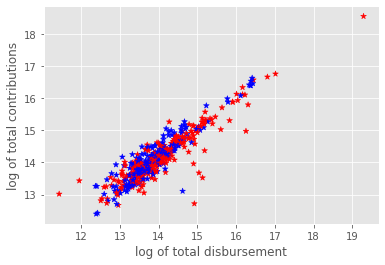

In [382]:
total_disbursement_win = np.log(winner_df["tot_dis"])
total_con_log_win = np.log(winner_df["tot_con"])
party_winner = winner_df['can_par_aff']

total_disbursement_lose = np.log(loser_df["tot_dis"])
total_con_log_lose = np.log(loser_df["tot_con"])
party_lose = loser_df['can_par_aff']

new_df_wins = pd.DataFrame(dict(party=party_winner, total_disbursement=total_disbursement_win, total_con_log=total_con_log_win))
new_df_lose = pd.DataFrame(dict(party=party_lose, total_disbursement=total_disbursement_lose, total_con_log=total_con_log_lose))


fig, ax = plt.subplots()
'REP', 'DEM', 'LIB', 'IND', 'GRE'
colors = {'REP': 'red', 'DEM': 'blue', 'IND': 'purple', 'LIB': 'yellow', 'GRE': 'green'}


ax.scatter(new_df_wins['total_disbursement'], new_df_wins['total_con_log'], c=new_df_wins['party'].map(colors), marker="*")
# ax.scatter(new_df_lose['total_disbursement'], new_df_lose['total_con_log'], c=new_df_lose['party'].map(colors), marker=".")


plt.xlabel('log of total disbursement')
plt.ylabel('log of total contributions')
# plt.title('Comparision of winning contributions and disbursement')

Text(0, 0.5, 'log of total contributions')

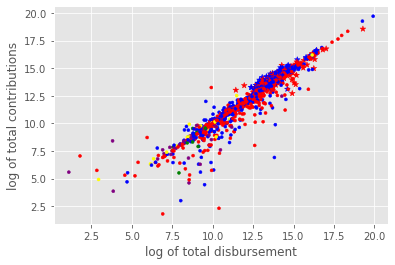

In [389]:
total_disbursement_win = np.log(winner_df["tot_dis"])
total_con_log_win = np.log(winner_df["tot_con"])
party_winner = winner_df['can_par_aff']

total_disbursement_lose = np.log(loser_df["tot_dis"])
total_con_log_lose = np.log(loser_df["tot_con"])
party_lose = loser_df['can_par_aff']

new_df_wins = pd.DataFrame(dict(party=party_winner, total_disbursement=total_disbursement_win, total_con_log=total_con_log_win))
new_df_lose = pd.DataFrame(dict(party=party_lose, total_disbursement=total_disbursement_lose, total_con_log=total_con_log_lose))


fig, ax = plt.subplots()
'REP', 'DEM', 'LIB', 'IND', 'GRE'
colors = {'REP': 'red', 'DEM': 'blue', 'IND': 'purple', 'LIB': 'yellow', 'GRE': 'green'}


ax.scatter(new_df_wins['total_disbursement'], new_df_wins['total_con_log'], c=new_df_wins['party'].map(colors), marker="*")
ax.scatter(new_df_lose['total_disbursement'], new_df_lose['total_con_log'], c=new_df_lose['party'].map(colors), marker=".")


plt.xlabel('log of total disbursement')
plt.ylabel('log of total contributions')
# plt.title('Comparision of losing contributions and disbursement')